# Классификация пола по изображению лица

---
## 1. Введение

Классификация изображений, содержащих лица людей. 

### 1.1 Задача
Определить пол человека по изображению.

### 1.2 Датасет

Датасет предоставлен компанией NtechLab

### 1.3 Оценка и результаты

В качестве оценки используется метрика accuracy.
Результат: файл process_results.json с информацией о результатах
процессинга.
Пример файла результатов:
{ ‘img_1.jpg’: ‘male’, ‘img_2.jpg’: ‘female’, ...}

### 1.4 Исходные данные

Некоторая информация о данных.
* Имеем дело и изображениями(неструктурированные данные), поэтому будем использовать deep/transfer learning
* Даны мужские и женские лица (это значит, что существует 2 класса)
* Данные не разделеы на тренировочную и тестовую выборку. Всего 50 тыс. картинок с изображением лиц женщин и 50 тыс. изображений
лиц мужчин. Файлы расположены в двух папках female и male.




## 2. Подготовим список labels c разметкой, а также список с путями к файлам.
Датафрейм будет состоять из двух столбцов в первом название изображения, во втором - класс (male или female)

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import os
import numpy as np
from IPython.display import Image,display

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.optimizers import SGD
import tensorflow as tf

In [2]:
# Подготовим директории файлов
directory_female = r'C:\Users\User\Jupiter\Gender_detetion\internship_data\female'
directory_male = r'C:\Users\User\Jupiter\Gender_detetion\internship_data\male'

In [3]:
# Найдем имена файлов
files_female = os.listdir(directory_female)
files_male = os.listdir(directory_male)
print(len(files_female))
print(len(files_male))

50002
50002


In [4]:
# Отфильтруем файлы, оставим только с расширением *.jpg
images_female = list(filter(lambda x: x.endswith('.jpg'), files_female))
images_male = list(filter(lambda x: x.endswith('.jpg'), files_male))
print(len(images_female))
print(len(images_male))

50001
50001


### Обозначим женские лица - 0, а мужские лица - 1

In [5]:
# Создадим дата фреймы с лейблами
df_female = pd.DataFrame({'name':images_female, 'Gender': '0'})
df_male = pd.DataFrame({'name':images_male, 'Gender': '1'})

In [6]:
df_male.head()

,name,Gender
0,000007.jpg,1
1,000012.jpg,1
2,000013.jpg,1
3,000020.jpg,1
4,000021.jpg,1


In [7]:
df_female.head()

,name,Gender
0,000001.jpg,0
1,000004.jpg,0
2,000009.jpg,0
3,000010.jpg,0
4,000022.jpg,0


In [8]:
# Объеденим два дата фрейма
frames = [df_female, df_male]
df =  pd.concat(frames, ignore_index=True)
len(df)
df[50001:50011]

,name,Gender
50001,000007.jpg,1
50002,000012.jpg,1
50003,000013.jpg,1
50004,000020.jpg,1
50005,000021.jpg,1
50006,000036.jpg,1
50007,000038.jpg,1
50008,000041.jpg,1
50009,000048.jpg,1
50010,000050.jpg,1


Проверим количество уникальных имен изображений

In [9]:
len(df['name'].unique().tolist())

100002

**Хорошо, значит повторяющихся имен изображений нет и мы не сможем запутаться при сопоставлении изображений с разметкой**

Перемешаем все данные в случайном порядке, сейчас идут сначала женские лица, затем мужские

In [10]:
df = df.sample(frac=1, random_state=42) # Укажем рэндом стейт для повторяемости

In [11]:
# Посмотрим как данные перемешались
df[:10]

,name,Gender
62004,048523.jpg,1
58589,034590.jpg,1
1956,008001.jpg,0
11529,046633.jpg,0
39495,161192.jpg,0
93481,174845.jpg,1
30102,122925.jpg,0
64227,057462.jpg,1
33356,136072.jpg,0
87432,150835.jpg,1


In [12]:
# Конвертируем тип переменной пол в int
df['Gender'] = df['Gender'].astype(int)

### Перемешаем пути к файлам, чтобы они соответствовали порядку в нашем df

In [13]:
# Теперь нужно составить список с путями к файлам
paths = []
for ind in  df.index:
    if df["Gender"][ind] > 0:
        paths.append(directory_male + "\\" + df["name"][ind])
    else:
        paths.append(directory_female + "\\" +  df["name"][ind])
paths[:10]

['C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\048523.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\034590.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\008001.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\046633.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\161192.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\174845.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\122925.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\057462.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\136072.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\150835.jpg']

**При сравнении первых 10 имен изображений в df и в списке видно, что пути правильно прописались**

**Сформируем numpy список для меток**

In [15]:
labels = df["Gender"].to_numpy()
labels

array([1, 1, 0, ..., 1, 0, 0])

**Проверим количество уникальных меток**

In [17]:
unique_labels = np.unique(labels)
len(unique_labels)

2

In [18]:
# Проверим количество меток совпадает с количеством путей к файлам
if len(labels) == len(paths):
  print("Количество меток совпадает с количеством путей!")
else:
  print("Количество меток не совпадает к количеством путей к ним. Проверьте путь к файлам")

Количество меток совпадает с количеством путей!


**Теперь нужно сформировать массив c метками**

In [21]:
# Коневертируем каждую метку в булевый массив
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:4]

[array([False,  True]),
 array([False,  True]),
 array([ True, False]),
 array([ True, False])]

## 3. Разделение подготовленных данных на тренировочную, валидирующую, тестовую

In [30]:
# Создадим Х и y
X = paths
y = boolean_labels

Разделим выборку на тренировочную и тестовую
Начнем экспериментировать с 1 000 изображений и будем увелчичивать количество изображений

In [328]:
# Зададим количество изображений для экспериментов
NUM_IMAGES = 1000 

In [329]:
# Разделим на тренировочную и валидирующую с количеством изображений равной NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES],
                                                  stratify=y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)


In [331]:
X_train[30:40]

['C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\050087.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\119742.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\184935.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\050993.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\156545.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\female\\041483.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\183199.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\045540.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\132751.jpg',
 'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\male\\145377.jpg']

In [332]:
y_train[30:40]

[array([ True, False]),
 array([False,  True]),
 array([False,  True]),
 array([ True, False]),
 array([False,  True]),
 array([ True, False]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])]

In [283]:
# sns.countplot([y_train[i].astype(int) for i in range(len(y_train))]);


In [284]:
# sns.countplot(y_val);

Хотя была использована опция stratify тренировочный и валидационный сет разбился не ровно 50/50, судя по всему потому, что в первая 1000 изображений содержит немного разное количество женских и мужских лиц. В приципе классы сбалансированы, но когда будет обучать модель на всем датасете разбиение будет 50/50, причем как для тренировочной, так и для валидационной выборки

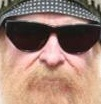

In [22]:
# Проверим, правильно ли указаны пути к файлам

display(Image(paths[5]))

**Случайно попали на такого серьезного дядьку :)**

In [23]:
# Определим размер изображения
IMG_height = 200
IMG_width = 200

# Создадим функцию для препроцессинга изображений

def process_image(image_path, img_height=IMG_height, img_width=IMG_width):
    """
    На вход подается путь к изображению и функция конвертирует изображение в тезор.
    """
    # Считаем изображение
    image = tf.io.read_file(image_path)
    # Конвертируем изображение в формате jpeg в числовой тензор с 3 каналами (красный, зеленый и синий)
    image = tf.image.decode_jpeg(image, channels=3)
    # Конвертируем каналы цвета из диапазано 0-255 в диапазон 0-1(нормализуем)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Изменим размер наших рисунков до (300, 300)
    image = tf.image.resize(image, size=(IMG_height, IMG_width))

    return image

**Проверим как работает наша функция**

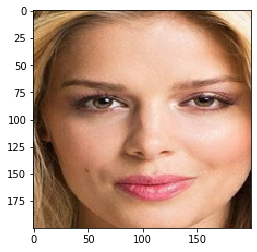

In [288]:
pic = process_image(X_train[0])
pic1 = img_to_array(pic)*255


plt.imshow((pic1).astype(np.uint8))
plt.show()

### 4. Создадим батчи наших изображений
Если мы попытаемся задействовать все 1000 (или больше)изображений за один раз, есть вероятность, что они не "поместятся" в оперативную память

Поэтому мы будем использовать пакет (batch), состоящий из 32 изображений (мы сможем вручну настроить размер пакета, если это необходимо).

Для того, чтобы ипользовать TensorFlow эффективно нам необходимо, чтобы наши данные находились в формате кортежа (typle), который выглядит слудующим образом: (image, label).

In [24]:
# Создадим функцию , которая возвращает кортеж (image, label)
def get_image_label(image_path, label):
    """
    Берет путь файла и его метку, подготавливает изображение и возвращает 
    кортеж (image, label).
    """

    image = process_image(image_path)
    return image, label

In [294]:
# Проверим как будет работать функция
(process_image(X[2]), tf.constant(y[2]))

(<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
 array([[[9.2580396e-01, 7.3364711e-01, 5.0227451e-01],
         [9.3463850e-01, 7.4248159e-01, 5.1110905e-01],
         [9.0729415e-01, 7.1200001e-01, 4.7435299e-01],
         ...,
         [5.9272158e-01, 6.1232942e-01, 5.9664315e-01],
         [5.9215689e-01, 6.1176473e-01, 5.9607846e-01],
         [5.9215689e-01, 6.1176473e-01, 5.9607846e-01]],
 
        [[9.3874514e-01, 7.4447066e-01, 5.1309806e-01],
         [9.2494124e-01, 7.3066670e-01, 4.9929416e-01],
         [9.0567851e-01, 7.0657259e-01, 4.7061965e-01],
         ...,
         [5.9529418e-01, 6.1532551e-01, 5.9963924e-01],
         [5.9190273e-01, 6.1362821e-01, 5.9794194e-01],
         [5.9003925e-01, 6.1176473e-01, 5.9607846e-01]],
 
        [[8.9450985e-01, 6.9843137e-01, 4.6705884e-01],
         [8.8070595e-01, 6.8462747e-01, 4.4704318e-01],
         [8.7129420e-01, 6.6894120e-01, 4.3301964e-01],
         ...,
         [5.9529418e-01, 6.1568630e-01, 6.0000002e-01],


**Теперь у нас есть возможность возвращать наши данные в виде кортежей тензоров (image, label) сделаем функцию для того, чтобы конвертировать наши данныые (X и y)**

In [25]:
# Определим размер батча, 32 это хороший размер
BATCH_SIZE = 32

# Создадим функцию для преобразования в батчи(пакеты)
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Создадает пакеты данных из изображений (X) и меток (y) в виде пары.
    Перемешивает данные если функция используется на тренировочной выборке, но не перемешивает - если
    на валидуриющей.
    Также позволяет подготовить тестовую выборку (в которой нет меток)
    """
    # Если выборка представлет их себя тестовый датасет у нас скорее  всего не будет меток для ее
    if test_data:
        print("Создаются пакеты для тестовой выборки...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Только пути к файлам (без меток)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # Если на вход поступает валидирующая выборка нам не нужно перемешивать ее
    elif valid_data:
        print("Создаются пакетs для валидирующей выборки...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # Пути к файлам
                                                   tf.constant(y))) #  метки
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)       
        return data_batch

    else:
        print("Создаются пакеты для тренировочной выборки...")    
    # Конвертируем пути файлов и метки в тензоры
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y))) 
        
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)  

        return data_batch

In [333]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Создаются пакеты для тренировочной выборки...
Создаются пакетs для валидирующей выборки...


In [297]:
# Проверим некоторые свойства наших батчей
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

## 5. Создадим и обучим модель. Будем использовать transfer learning. В качестве модели возьмем InceptionV3.

In [253]:
inc_model = InceptionV3(weights="imagenet", 
                        include_top=False, 
                        input_shape=(IMG_height,IMG_width,3))

print("number of layers in the model : ", len(inc_model.layers))

87916544/87910968 [==============================] - 18s 0us/step
number of layers in the model :  311


**Верхние слои (включая классификацию не включены). Эти слои будут замещены следующими слоями:**

In [336]:
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [337]:
# Создадим итоговую модель

model_ = Model(inputs=inc_model.input, outputs=predictions)

# Залочим слои, чтоб они не были обучены

for layer in model_.layers[:52]:
    layer.trainable = False
    
# Скомпилируем модель

model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [338]:
# Введем callback ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', verbose=1, save_best_only=True)

In [339]:
# Обучим модель
num_epochs = 5
hist = model_.fit(x=train_data,
                 epochs=num_epochs,
                 validation_data=val_data,
                 validation_freq=1,
                 steps_per_epoch=len(X_train)/BATCH_SIZE,
                 callbacks=[checkpointer],
                 verbose=1)

Epoch 1/5
2501/2500 [==============================] - ETA: -10s - loss: 0.3192 - accuracy: 0.8545
Epoch 00001: val_loss improved from inf to 0.15437, saving model to weights.best.inc.male.hdf5
2501/2500 [==============================] - 29024s 12s/step - loss: 0.3192 - accuracy: 0.8545 - val_loss: 0.1544 - val_accuracy: 0.9386
Epoch 2/5

Epoch 00002: val_loss did not improve from 0.15437
   0/2500 [..............................] - 0s 0s/step - loss: 0.3192 - accuracy: 0.8545 - val_loss: 0.1544 - val_accuracy: 0.9386


*Примечание:*
При попытке обучить модель на всех изображениях машина выдает предупреждеие. Так как в тренировочном сете 80001 изображение, а размер  батча 32, количето шагов в одной эпохе (то steps_per_epoch)
не целое число немного больше 2500, из-за этого несколько изображений не попали в обучение в 1 эпоху, необходимо было 
вместо steps_per_epoch=len(X_train)/BATCH_SIZE задать steps_per_epoch=len(X_train)//BATCH_SIZE, тогда бы предупреждения
не было и пару изображений не попало б в обучение. В качестве альтернативы, можно было бы округлить значение, до
наибольшего целокого steps_per_epoch=math.ceil(len(X_train)/BATCH_SIZE) и тогда количество шагов было бы 2501 и несколько 
картинок попало бы по второму разу на обучение в одну и ту же эпоху.
https://stackoverflow.com/questions/54575714/combining-keras-model-fits-steps-per-epoch-with-tensorflows-dataset-apis-b
Судя по всему из-за этого предупреждения вторая эпоха не запустилась. Нужно больше времени, чтобы разобраться в этом.

### 7.Сохранение модели и метрика

In [318]:
# Создадим функцию для сохранения модели
def save_model(model, suffix=None):
    """
    Сохраняет данную модель в директорию models и добавляет суффикс(текст)
    """
    # Создадим путь к модели, а также текущее время
    directory = r'C:\Users\User\Jupiter\Gender_detetion\internship_data\models'
    modeldir = os.path.join(directory, 
                            datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
    model_path = modeldir + "_" + suffix + ".h5" # расширение модели
    print(f"Сохранение модели в: {model_path}...")
    model.save(model_path)
    return model_path

In [340]:
# save_model(model_, suffix='100002_img')

Сохранение модели в: C:\Users\User\Jupiter\Gender_detetion\internship_data\models\08-09-2020_07-36-13_100002_img.h5...


'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\models\\08-09-2020_07-36-13_100002_img.h5'

**Так как на обученной модели с 100 тыс. изображений обучение законилось на 1-ой эпохе, графики нерепрезентативны**

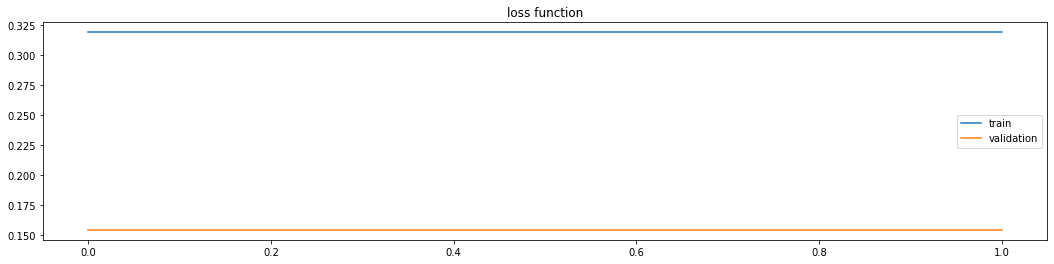

In [341]:
# Функция потерь 

plt.figure(figsize=(18,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()

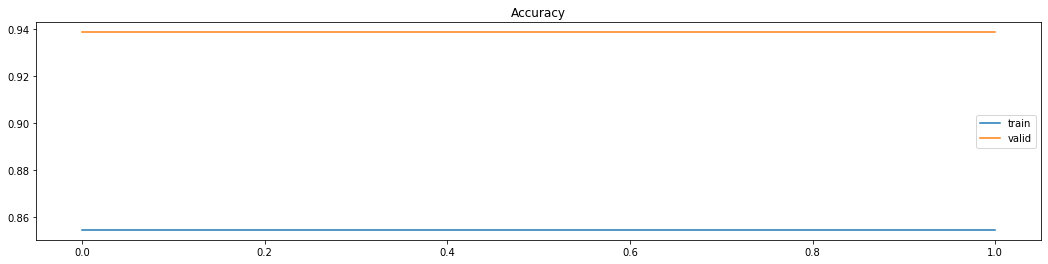

In [344]:
# График accuracy по эпохам
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

Так как  в модели с 100 тыс. обучающих изображений модель обучилась всего на одной эпохе, то графики метрики получились не репрезентативными. Для лучших показателей, нужно большее количество эпох. 
Также нужно было оставить фотографии для тестовой выборки для оценки точности модели.

Ранее была обучена модель на 1 тыс изображений, на ней можно оценить функцию потерь и точность (accuracy) по эпохам, а также точность на тестирующей выборке.

In [351]:
# model_1000 = tf.keras.models.load_model("C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\models\\07-09-2020_22-53-48_1000_img.h5")

К сожалению формат h5 не сохраняет историю, поэтому, чтоб оценить модель, нужно ее заново обучать
https://stackoverflow.com/questions/57519131/how-to-load-history-from-saved-model-h5-file

### 8. Дополнение. 
Обучим модель на 10к изображений и посомотрим её метрики.

In [31]:
# Количество изображений
NUM_IMAGES = 10000

# Количество эпох
num_epochs = 8

# Разделим на тренировочную и валидирующую с количеством изображений равной NUM_IMAGES
X_train_10k, X_val_10k, y_train_10k, y_val_10k = train_test_split(X[:NUM_IMAGES], 
                                                                  y[:NUM_IMAGES],
                                                                  stratify=y[:NUM_IMAGES],
                                                                  test_size=0.2,
                                                                  random_state=42)
# Создадим тестовую выборку
X_test_10k = X[10001:12001]
y_test_10k = y[10001:12001]

In [32]:
train_data_10k = create_data_batches(X_train_10k, y_train_10k)
val_data_10k = create_data_batches(X_val_10k, y_val_10k, valid_data=True)
test_data_10k = create_data_batches(X_test_10k, y_test_10k, valid_data=True)

Создаются пакеты для тренировочной выборки...
Создаются пакетs для валидирующей выборки...
Создаются пакетs для валидирующей выборки...


In [33]:
len(train_data_10k), len(val_data_10k), len(test_data_10k)

(250, 63, 63)

**Обучим модель на 10к. изображений, количество эпох намерено установлено побольше**

In [366]:
hist_10k = model_.fit(x=train_data_10k,
                      epochs=num_epochs,
                      validation_data=val_data_10k,
                      validation_freq=1,
                      steps_per_epoch=len(X_train_10k)/BATCH_SIZE,
                      callbacks=[checkpointer],
                      verbose=1)

Epoch 1/8
250/250 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9310
Epoch 00001: val_loss improved from 0.15437 to 0.14039, saving model to weights.best.inc.male.hdf5
250/250 [==============================] - 2615s 10s/step - loss: 0.1726 - accuracy: 0.9310 - val_loss: 0.1404 - val_accuracy: 0.9440
Epoch 2/8
250/250 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9565
Epoch 00002: val_loss improved from 0.14039 to 0.13646, saving model to weights.best.inc.male.hdf5
250/250 [==============================] - 2465s 10s/step - loss: 0.1186 - accuracy: 0.9565 - val_loss: 0.1365 - val_accuracy: 0.9440
Epoch 3/8
250/250 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9754
Epoch 00003: val_loss improved from 0.13646 to 0.13580, saving model to weights.best.inc.male.hdf5
250/250 [==============================] - 2525s 10s/step - loss: 0.0819 - accuracy: 0.9754 - val_loss: 0.1358 - val_accuracy: 0.9465
Epoch 4/8
250/25

In [367]:
# save_model(model_, suffix='10000_img')

Сохранение модели в: C:\Users\User\Jupiter\Gender_detetion\internship_data\models\08-09-2020_14-52-49_10000_img.h5...


'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\models\\08-09-2020_14-52-49_10000_img.h5'

**Теперь можно посмотреть функцию потерь и точность прогноза на тренировочной и валидирующей выборке**

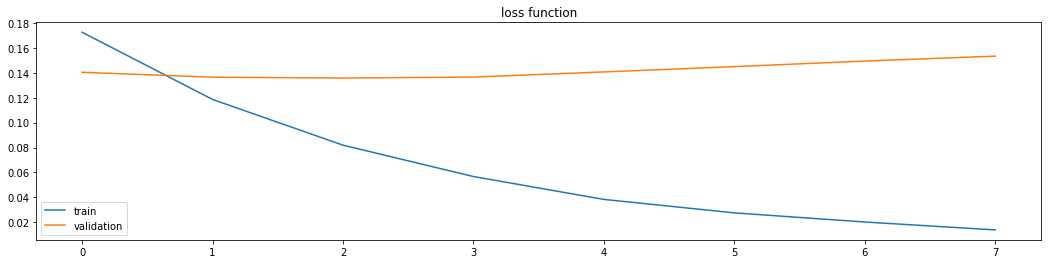

In [368]:
# Функция потерь 

plt.figure(figsize=(18,4))
plt.plot(hist_10k.history['loss'], label='train')
plt.plot(hist_10k.history['val_loss'], label='validation')
plt.legend()
plt.title('loss function')
plt.show()

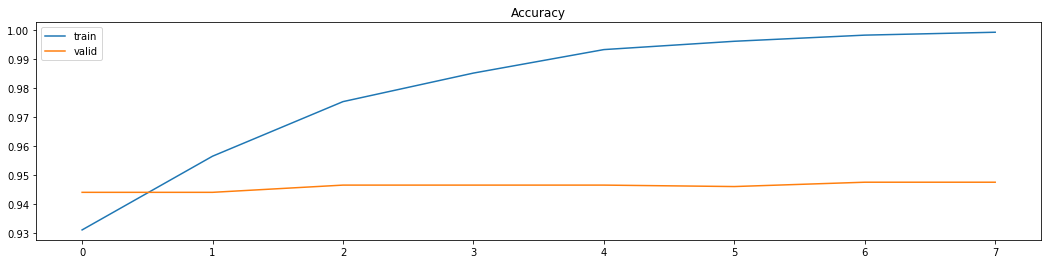

In [369]:
# График accuracy по эпохам
plt.figure(figsize=(18, 4))
plt.plot(hist_10k.history['accuracy'], label = 'train')
plt.plot(hist_10k.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

Функция потерь и точность макимальны после обучения третьей эпохи, поэтому функция callback сохранила именно эти веса.

### 8.1 Проверим точность модели (обученной на 10к изображений) на тестовой выборке

**Загрузим модель**

In [35]:
model_10k_path =r'C:\\Users\\User\\Jupiter\\Gender_detetion\\internship_data\\models\\08-09-2020_14-52-49_10000_img.h5'

In [36]:
model_10k = tf.keras.models.load_model(model_10k_path)

**Сделаем прогноз**

In [61]:
predictions = model_10k.predict(test_data_10k, verbose=1)

63/63 [==============================] - 193s 3s/step


In [39]:
#Проверим результат(результат выводится в виде массива вероятностей принадлежности изображения к каждому классу)
predictions[:10]

array([[5.6635891e-03, 9.9433643e-01],
       [7.7743542e-01, 2.2256459e-01],
       [9.7697790e-05, 9.9990225e-01],
       [9.9990606e-01, 9.3881419e-05],
       [4.5357960e-01, 5.4642034e-01],
       [1.4367682e-02, 9.8563230e-01],
       [1.6071797e-04, 9.9983931e-01],
       [6.9595662e-05, 9.9993038e-01],
       [7.8139637e-05, 9.9992180e-01],
       [9.9819034e-01, 1.8096201e-03]], dtype=float32)

**Конвертируем наш прогноз в классификацию (0 и 1)**

In [62]:
pred_np = np.round(predictions, 0).astype(int)
pred_np[:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]])

**Посмотрим как выглядят тестовая выборка**

In [45]:
y_test_10k[:10]

[array([False,  True]),
 array([ True, False]),
 array([False,  True]),
 array([ True, False]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([ True, False])]

**Преобразуем в массив numpy**

In [63]:
y_test_10k_np = np.array(y_test_10k).astype(int)
y_test_10k_np[:10]

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]])

**Оценим точность модели**

In [72]:
evaluation = pred_np == y_test_10k_np
accuracy = (np.sum(evaluation.astype(int))/2)/len(y_test_10k)*100
print("Точность модели на тестовой выборке:", accuracy)

Точность модели на тестовой выборке: 94.55


**Отлично! Точность модели на тренировочной выборке не сильно уступает точности на валидирующей выборке (94,65 %), значит мы не переобучили модель**